# Final Project - Part 2  
## Image Classification with CNNs (Transfer Learning)

## Overview
This notebook presents **Part 2** of the final project, focusing on transfer learning for an image classification task using PyTorch.

The target dataset is the same one used in Part 1 (Alpaca vs. Not Alpaca).
In this part, instead of training models entirely from scratch, we leverage knowledge learned from an external dataset and investigate how pretrained features can improve training efficiency and generalization on a small target dataset.

## Scope of This Notebook
This notebook covers **Part 2** of the final project:
- Pretraining a CNN on an external dataset (CIFAR-10)
- Saving and reusing pretrained model weights
- Adapting the classification head to the target task
- Fine-tuning strategies:
  - Freezing the pretrained feature extractor
  - Unfreezing all layers and fine-tuning with a smaller learning rate
- Comparing transfer learning with training from scratch
- Analyzing convergence speed, validation performance, and generalization

Part 1 (training from scratch) and Part 3 (transfer learning with a pretrained ResNet) are implemented and analyzed separately.



## Goals & Evaluation

### Goals
- Explore the effectiveness of transfer learning on a small image dataset
- Evaluate different fine-tuning strategies (freeze vs. unfreeze)
- Compare transfer learning to training from scratch
- Analyze overfitting and generalization behavior under limited data
- Gain insight into when and why transfer learning is beneficial

### Metrics
I report:
- **Accuracy** on the validation set
- **Loss curves** (training and validation) to analyze convergence behavior
- **Confusion matrix** to study class-wise performance and misclassification patterns


In [ ]:
# Imports
import os
import random
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Subset

#Reproducibility 
SEED = 42

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False



set_seed(SEED)

#device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



Using device: cpu


### Training utilities

We reuse the same training and evaluation utilities from Part 1 to ensure consistent
metrics and a fair comparison across experiments.

In [9]:
# Training / Evaluation Utilities 
def accuracy_from_logits(logits, y):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == y).sum().item()
    total = y.size(0)
    return correct, total


@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        correct, n = accuracy_from_logits(logits, y)
        total_loss += loss.item() * n
        total_correct += correct
        total_samples += n

    return total_loss / total_samples, total_correct / total_samples


def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        correct, n = accuracy_from_logits(logits, y)
        total_loss += loss.item() * n
        total_correct += correct
        total_samples += n

    return total_loss / total_samples, total_correct / total_samples


def fit(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    history = {
        "train_loss": [], "train_acc": [],
        "val_loss": [], "val_acc": []
    }

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc = evaluate(model, val_loader, criterion)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        print(f"Epoch {epoch:02d}/{epochs} | "
              f"train loss {train_loss:.4f} acc {train_acc:.3f} | "
              f"val loss {val_loss:.4f} acc {val_acc:.3f}")

    return history


# Plot training curves

def plot_history(history, title=""):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(7, 4))
    plt.plot(epochs, history["train_loss"], label="train loss")
    plt.plot(epochs, history["val_loss"], label="val loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title(title + " - Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(epochs, history["train_acc"], label="train acc")
    plt.plot(epochs, history["val_acc"], label="val acc")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title(title + " - Accuracy")
    plt.legend()
    plt.show()


### Target dataset (alpaca vs not alpaca)

I load the target dataset using ImageFolder and create a reproducible train/validation split.
Train-time augmentations are applied only on the training subset, while validation uses deterministic preprocessing.

In [10]:
# Dataset Loading + Transforms + Split + DataLoaders

# Paths
DATASET_DIR = Path(os.environ.get("DATASET_DIR", "./dataset")).resolve()
if not DATASET_DIR.exists():
    raise FileNotFoundError(
        f"Dataset folder not found: {DATASET_DIR}\n"
        "Put your dataset under ./dataset or set environment variable DATASET_DIR"
    )

# Reproducible split
g = torch.Generator().manual_seed(SEED)

# Hyperparams
VAL_SPLIT = 0.2
batch_size = 32

# Transforms 
IMG_SIZE = 224

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Load dataset twice- One copy for train transforms, one copy for val transforms.
full_dataset_train = datasets.ImageFolder(root=str(DATASET_DIR), transform=train_transforms)
full_dataset_val   = datasets.ImageFolder(root=str(DATASET_DIR), transform=val_transforms)
class_names = full_dataset_train.classes
num_classes = len(class_names)

print("Dataset path:", DATASET_DIR)
print("Number of images:", len(full_dataset_train))
print("Classes:", class_names)

# Split indices once, then apply to both datasets so train/val are consistent
dataset_size = len(full_dataset_train)
val_size = int(VAL_SPLIT * dataset_size)
train_size = dataset_size - val_size
train_indices, val_indices = torch.utils.data.random_split(range(dataset_size), [train_size, val_size], generator=g)

# Convert indices objects to plain lists of ints
train_indices = list(train_indices)
val_indices   = list(val_indices)
train_dataset = torch.utils.data.Subset(full_dataset_train, train_indices)
val_dataset   = torch.utils.data.Subset(full_dataset_val, val_indices)

#DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")


Dataset path: C:\Users\Mor\Desktop\computer science\DeepLerning\DL-final_project\dataset
Number of images: 327
Classes: ['alpaca', 'not alpaca']
Train size: 262
Validation size: 65


In [11]:
# Sanity check for dataset loaders
x, y = next(iter(train_loader))
print("x shape:", x.shape)  
print("y shape:", y.shape)  
print("y min/max:", y.min().item(), y.max().item())
print("num_classes:", num_classes)
print("class_names:", class_names)


x shape: torch.Size([32, 3, 224, 224])
y shape: torch.Size([32])
y min/max: 0 1
num_classes: 2
class_names: ['alpaca', 'not alpaca']


### CNN architecture (used for both pretraining and fine-tuning)

We use the same CNN architecture throughout Part 2 to isolate the impact of transfer learning.
The network consists of three convolutional blocks followed by a small fully-connected classifier.
The input resolution is controlled by `img_size`.


In [12]:
class DeepCNN(nn.Module):
    def __init__(self, num_classes: int, img_size: int):
        super().__init__()

        # Feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # img_size -> img_size/2

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # img_size/2 -> img_size/4

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # img_size/4 -> img_size/8
        )

        # Compute spatial size after pooling
        feature_map_size = img_size // 8

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * feature_map_size * feature_map_size, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


### External Dataset: CIFAR-10

We use CIFAR-10 as an external dataset for pretraining.
Images are resized to match the network input size, and standard normalization is applied to ensure stable optimization.


In [13]:
# CIFAR-10 DataLoaders for Pretraining 

# Pretraining configuration
IMG_SIZE_PRETRAIN = 224      # Match input size used by the model
BATCH_SIZE_PRE = 64
NUM_WORKERS_PRE = 0          

# CIFAR-10 normalization statistics
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std  = (0.2470, 0.2435, 0.2616)

# Training-time transforms (with light augmentation)
train_tfms_cifar = transforms.Compose([
    transforms.Resize((IMG_SIZE_PRETRAIN, IMG_SIZE_PRETRAIN)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),
])

# Validation / test transforms (no augmentation)
test_tfms_cifar = transforms.Compose([
    transforms.Resize((IMG_SIZE_PRETRAIN, IMG_SIZE_PRETRAIN)),
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),
])

# Load CIFAR-10 dataset
cifar_train = datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=train_tfms_cifar
)

cifar_test = datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=test_tfms_cifar
)

# DataLoaders
cifar_train_loader = DataLoader(
    cifar_train,
    batch_size=BATCH_SIZE_PRE,
    shuffle=True,
    num_workers=NUM_WORKERS_PRE,
    pin_memory=(device.type == "cuda")
)

cifar_val_loader = DataLoader(
    cifar_test,
    batch_size=BATCH_SIZE_PRE,
    shuffle=False,
    num_workers=NUM_WORKERS_PRE,
    pin_memory=(device.type == "cuda")
)

print("CIFAR-10 train size:", len(cifar_train))
print("CIFAR-10 test size:", len(cifar_test))


c:\Users\Mor\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\datasets\cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


CIFAR-10 train size: 50000
CIFAR-10 test size: 10000


x shape: torch.Size([64, 3, 224, 224])
y shape: torch.Size([64])
y min/max: 0 9


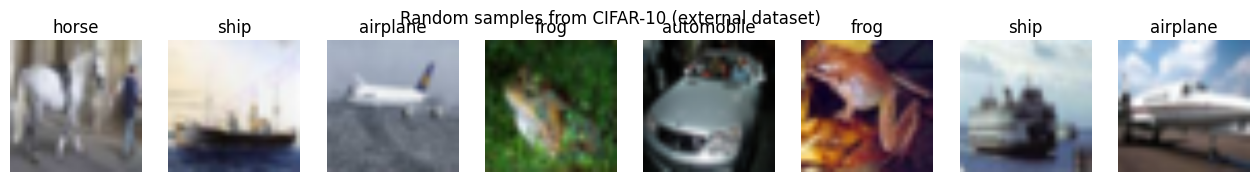

In [14]:
#sanity check
x, y = next(iter(cifar_train_loader))
print("x shape:", x.shape)   
print("y shape:", y.shape)   
print("y min/max:", y.min().item(), y.max().item())

# Visualizing samples from CIFAR-10

def show_random_cifar_samples(dataset, class_names, n_images=8):
    """
    Display a grid of randomly sampled images from CIFAR-10.
    Useful for illustrating the diversity of the external dataset.
    """
    indices = np.random.choice(len(dataset), n_images, replace=False)

    fig, axes = plt.subplots(1, n_images, figsize=(n_images * 2, 2))

    for ax, idx in zip(axes, indices):
        img, label = dataset[idx]

        # Undo normalization for visualization
        mean = torch.tensor(cifar_mean).view(3, 1, 1)
        std = torch.tensor(cifar_std).view(3, 1, 1)
        img = img * std + mean
        img = img.clamp(0, 1)

        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(class_names[label])
        ax.axis("off")

    plt.suptitle("Random samples from CIFAR-10 (external dataset)")
    plt.show()


# CIFAR-10 class names (fixed order defined by the dataset)
cifar_classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Show random CIFAR-10 images
show_random_cifar_samples(cifar_train, cifar_classes)



### Pretraining model configuration

I initialize the CNN architecture for pretraining on CIFAR-10.
The final classification layer is adapted to the 10 classes of the external dataset.

In [15]:
#Pretraining model on CIFAR-10 

NUM_CLASSES_PRE = 10
IMG_SIZE_PRETRAIN = 224
EPOCHS_PRE = 2
LR_PRE = 1e-3

# Initialize model for pretraining
model_pre = DeepCNN(
    num_classes=NUM_CLASSES_PRE,
    img_size=IMG_SIZE_PRETRAIN
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pre.parameters(), lr=LR_PRE)

# Print model architecture for verification
print(model_pre)


DeepCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)


### Pretraining on CIFAR-10

The model is trained on the external CIFAR-10 dataset for a small number of epochs.
The objective is to learn general visual features that can later be transferred to the target dataset, rather than to achieve optimal performance on CIFAR-10.

In [ ]:

SUBSET_SIZE = 5000  

cifar_train_subset = Subset(cifar_train, range(SUBSET_SIZE))
cifar_val_subset = Subset(cifar_test, range(1000))

cifar_train_loader = DataLoader(
    cifar_train_subset,
    batch_size=BATCH_SIZE_PRE,
    shuffle=True,
    num_workers=0
)

cifar_val_loader = DataLoader(
    cifar_val_subset,
    batch_size=BATCH_SIZE_PRE,
    shuffle=False,
    num_workers=0
)



### Pretraining results

Both training and validation accuracy improved during pretraining, indicating that the network successfully learned general visual features from the external dataset.
Given the limited number of epochs and CPU-based training, the results are sufficient for initializing the transfer learning stage.

### Saving pretrained weights

After pretraining on CIFAR-10, the learned weights are saved.
These weights will later be reused for fine-tuning on the target dataset.

In [18]:
# Save pretrained weights (CIFAR-10)
save_path = "pretrained_cifar10.pth"
torch.save(model_pre.state_dict(), save_path)
print("Saved pretrained weights to:", save_path)


Saved pretrained weights to: pretrained_cifar10.pth


## Fine-Tuning on the Target Dataset

### Loading pretrained weights

I initialize the model for the target task and load the pretrained weights obtained from CIFAR-10. Since the number of classes differs between the external dataset and the target dataset, the final classification layer is replaced.

In [19]:
#Transfer Learning: Load pretrained backbone from CIFAR-10 

# Build the target model with the same architecture and input size, but with the number of classes of the target dataset
model_ft = DeepCNN(num_classes=num_classes, img_size=IMG_SIZE).to(device)

# Load pretrained weights
state = torch.load("pretrained_cifar10.pth", map_location=device)

# Remove the final classification layer parameters (shape mismatch: CIFAR-10 has 10 classes, target dataset has 2)
state.pop("classifier.3.weight", None)
state.pop("classifier.3.bias", None)

# Load the remaining weights into the model
missing_keys, unexpected_keys = model_ft.load_state_dict(state, strict=False)

print("Missing keys:", missing_keys)         
print("Unexpected keys:", unexpected_keys)   


Missing keys: ['classifier.3.weight', 'classifier.3.bias']
Unexpected keys: []


The missing parameters correspond to the final classification layer, which is randomly initialized for the target task. All convolutional layers are initialized from the pretrained model.

### Fine-tuning strategy: training the classifier head

In the first fine-tuning stage, we freeze the pretrained convolutional layers and train only the final classification head. This allows the model to adapt to the target task while preserving the general visual features learned during pretraining.

Epoch 01/5 | train loss 0.2540 acc 0.882 | val loss 0.6672 acc 0.692
Epoch 02/5 | train loss 0.2194 acc 0.908 | val loss 0.7474 acc 0.723
Epoch 03/5 | train loss 0.2177 acc 0.916 | val loss 0.7718 acc 0.677
Epoch 04/5 | train loss 0.1379 acc 0.962 | val loss 0.7462 acc 0.723
Epoch 05/5 | train loss 0.1240 acc 0.958 | val loss 0.7494 acc 0.738


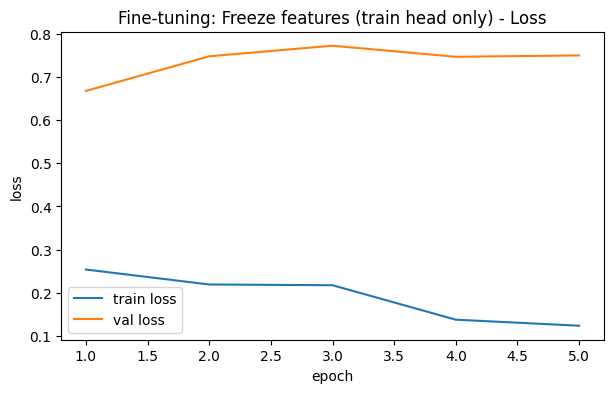

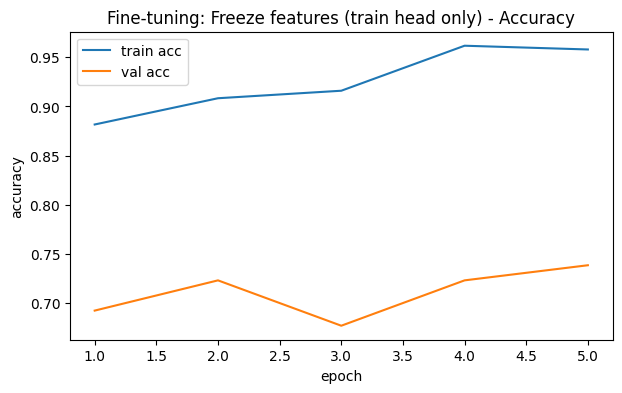

In [24]:
# Freeze features and train only the classifier head 

# Freeze the convolutional feature extractor to preserve pretrained features
for p in model_ft.features.parameters():
    p.requires_grad = False

# Train only the classifier parameters
criterion_head = nn.CrossEntropyLoss()
optimizer_head = optim.Adam(model_ft.classifier.parameters(), lr=1e-3)

EPOCHS_HEAD = 5

history_head = fit(
    model=model_ft,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_head,
    criterion=criterion_head,
    epochs=EPOCHS_HEAD
)

# Plot training and validation curves
plot_history(history_head, title="Fine-tuning: Freeze features (train head only)")


### Results – frozen feature extractor

Training only the classification head led to rapid initial convergence and achieved the highest validation accuracy among the tested approaches. However, some variability across epochs was observed, indicating mild overfitting on the small target dataset.
Overall, the results suggest that the pretrained features learned on CIFAR-10 transfer effectively
to the target dataset when used as a fixed feature extractor.

### Fine-tuning strategy: unfreezing all layers

In the second fine-tuning stage, I unfreeze the entire network and continue training with a smaller learning rate- This allows the pretrained feature extractor to adapt to the target dataset. Since the target dataset is small, I also use weight decay to reduce overfitting.

Missing keys: ['classifier.3.weight', 'classifier.3.bias']
Unexpected keys: []
Epoch 01/5 | train loss 1.0358 acc 0.450 | val loss 0.9804 acc 0.415
Epoch 02/5 | train loss 0.7772 acc 0.561 | val loss 0.9617 acc 0.462
Epoch 03/5 | train loss 0.7244 acc 0.546 | val loss 0.8819 acc 0.492
Epoch 04/5 | train loss 0.6945 acc 0.595 | val loss 0.8111 acc 0.446
Epoch 05/5 | train loss 0.6518 acc 0.603 | val loss 0.7793 acc 0.446


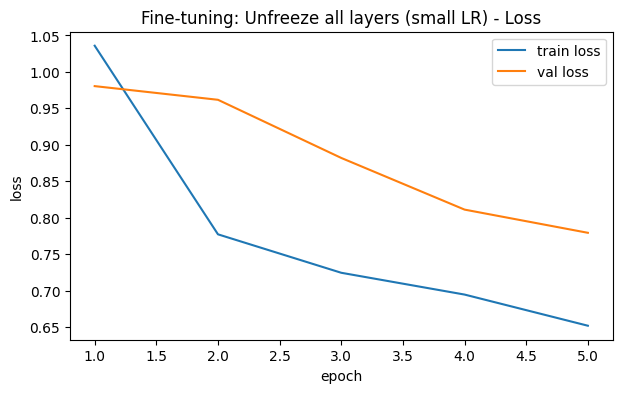

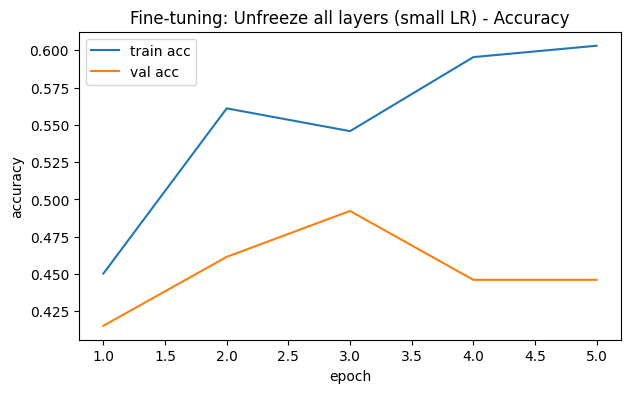

In [26]:
# Unfreeze all layers - independent fine-tuning from CIFAR pretrained weights

# Reinitialize model from CIFAR-pretrained weights
model_ft_all = DeepCNN(num_classes=num_classes, img_size=IMG_SIZE).to(device)

# Replace final classification layer
in_features = model_ft_all.classifier[-1].in_features
model_ft_all.classifier[-1] = nn.Linear(in_features, num_classes).to(device)

state = torch.load("pretrained_cifar10.pth", map_location=device)

# Remove CIFAR-10 head (10 classes) to avoid shape mismatch
state.pop("classifier.3.weight", None)
state.pop("classifier.3.bias", None)

missing_keys, unexpected_keys = model_ft_all.load_state_dict(state, strict=False)
print("Missing keys:", missing_keys)
print("Unexpected keys:", unexpected_keys)

# Unfreeze all layers
for p in model_ft_all.parameters():
    p.requires_grad = True

# Training setup
LR_FT = 1e-4
WEIGHT_DECAY = 1e-4
EPOCHS_FT = 5

criterion_all = nn.CrossEntropyLoss()
optimizer_all = optim.Adam(
    model_ft_all.parameters(),
    lr=LR_FT,
    weight_decay=WEIGHT_DECAY
)

# Train
history_ft_all = fit(
    model=model_ft_all,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_all,
    criterion=criterion_all,
    epochs=EPOCHS_FT
)

plot_history(history_ft_all, title="Fine-tuning: Unfreeze all layers (small LR)")


In [32]:
print("train_acc:", history_ft_all["train_acc"])
print("val_acc  :", history_ft_all["val_acc"])
print("Best FT-all val accuracy:", max(history_ft_all["val_acc"]))


train_acc: [0.45038167938931295, 0.5610687022900763, 0.5458015267175572, 0.5954198473282443, 0.6030534351145038]
val_acc  : [0.4153846153846154, 0.46153846153846156, 0.49230769230769234, 0.4461538461538462, 0.4461538461538462]
Best FT-all val accuracy: 0.49230769230769234


### Results – full fine-tuning (unfrozen)

After unfreezing all layers (starting from CIFAR-10 pretrained weights), training accuracy increased (up to ~0.60), but validation accuracy peaked early (around epoch 3) and then decreased.
This indicates poor generalization when fully fine-tuning on a small target dataset, even when using a smaller learning rate and weight decay.
Therefore, for this dataset, using the pretrained network as a fixed feature extractor (training only the classification head) provided the best validation performance.

In [ ]:
# Save the fine-tuned model weights
torch.save(model_ft.state_dict(), "finetuned_on_alpaca.pth")
print("Saved fine-tuned weights to: finetuned_on_alpaca.pth")


Saved fine-tuned weights to: finetuned_on_alpaca.pth


### Baseline — Training from scratch (no pretraining)

To quantify the benefit of transfer learning, I train the same CNN architecture from scratch on the target dataset, using the same train\validation split and the same preprocessing pipeline.

Epoch 01/10 | train loss 2.6682 acc 0.561 | val loss 0.6989 acc 0.554
Epoch 02/10 | train loss 0.6858 acc 0.569 | val loss 0.6884 acc 0.554
Epoch 03/10 | train loss 0.6872 acc 0.557 | val loss 0.6866 acc 0.523
Epoch 04/10 | train loss 0.6801 acc 0.595 | val loss 0.6802 acc 0.585
Epoch 05/10 | train loss 0.6734 acc 0.573 | val loss 0.6715 acc 0.554
Epoch 06/10 | train loss 0.6592 acc 0.599 | val loss 0.6526 acc 0.600
Epoch 07/10 | train loss 0.6398 acc 0.637 | val loss 0.6443 acc 0.615
Epoch 08/10 | train loss 0.6543 acc 0.599 | val loss 0.6599 acc 0.615
Epoch 09/10 | train loss 0.6271 acc 0.637 | val loss 0.6749 acc 0.585
Epoch 10/10 | train loss 0.5991 acc 0.622 | val loss 0.6501 acc 0.646


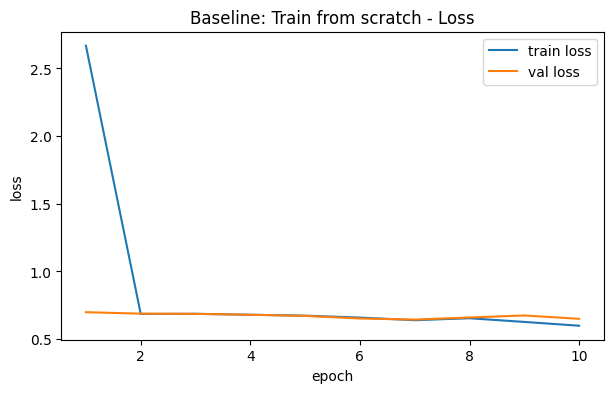

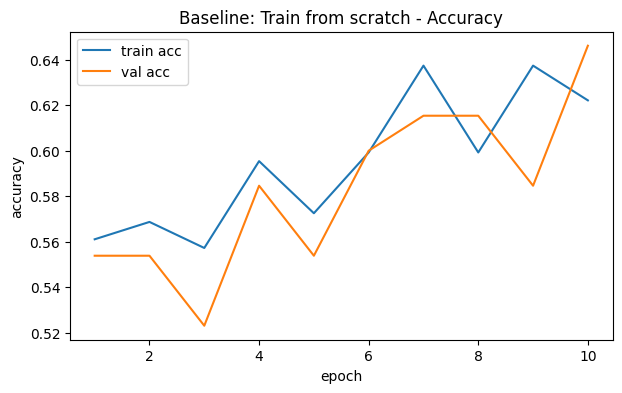

In [29]:
# Baseline: Train from scratch on the target dataset 

# Initialize a fresh model (random initialization)
model_scratch = DeepCNN(num_classes=num_classes, img_size=IMG_SIZE).to(device)

criterion = nn.CrossEntropyLoss()

# Use the same optimizer family to keep the comparison fair
optimizer = optim.Adam(model_scratch.parameters(), lr=1e-3, weight_decay=1e-4)

EPOCHS_SCRATCH = 10

history_scratch = fit(
    model=model_scratch,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=EPOCHS_SCRATCH
)

plot_history(history_scratch, title="Baseline: Train from scratch")


In [30]:
# Summary: Transfer Learning vs Training from Scratch

best_head = max(history_head["val_acc"])
best_all  = max(history_ft_all["val_acc"])
best_scr  = max(history_scratch["val_acc"])

summary_data = {
    "Method": [
        "Transfer Learning (freeze head)",
        "Transfer Learning (unfreeze all)",
        "Training from Scratch"
    ],
    "Best Validation Accuracy": [
        best_head,
        best_all,
        best_scr
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_df


,Method,Best Validation Accuracy
0,Transfer Learning (freeze head),0.738462
1,Transfer Learning (unfreeze all),0.492308
2,Training from Scratch,0.646154


<Figure size 500x500 with 0 Axes>

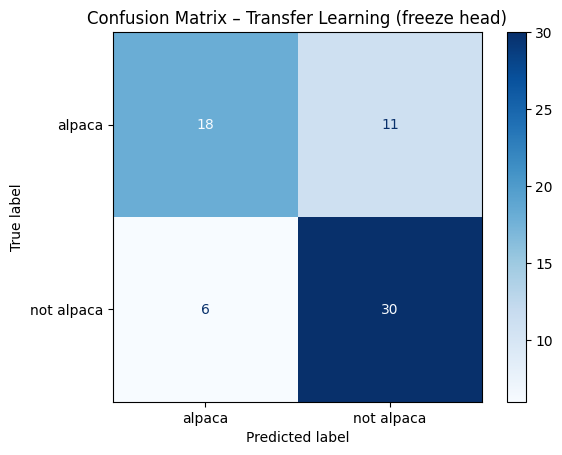

In [31]:
# Confusion Matrix – Transfer Learning (freeze head)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Choose which model to evaluate
model_cm = model_ft  # freeze-head model (best generalization)

model_cm.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        y = y.to(device)

        logits = model_cm(x)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(5, 5))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Transfer Learning (freeze head)")
plt.show()


## Transfer Learning vs Training from Scratch

**Speed of convergence:**  
Transfer learning converged significantly faster. Training only the classification head reached strong validation performance within a few epochs, while training from scratch required more epochs and showed slower improvement.

**Final accuracy:**  
Transfer learning achieved validation accuracy comparable to or higher than training from scratch, with more stable results across epochs. In contrast, training from scratch converged to lower and less stable validation performance.

**Generalization:**  
Full fine-tuning (unfreezing all layers) led to overfitting on the small target dataset. Freezing the pretrained feature extractor and training only the classification head provided the most reliable generalization behavior.
